# Assignment 1: Cornelis de Jager n8891974

In [31]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as stats

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import ML libraries
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import VotingClassifier

# Set a random state value
rs = 10

#import libraries to visualize decision trees
import pydot
from io import StringIO


# Ignore Warnings and ignore them
import warnings
warnings.filterwarnings("ignore")

In [35]:
def categoricalPlot(cat, cat2 = 'IsBadBuy'): # Cat is the carigorical as a string i.e 'Size'
    pd.crosstab(data[cat],data[cat2]).plot(kind="bar")
    
def CreateAveragedColumn (A, B):
    C = [np.nan] * len( A )
    for i in range(len(A)):
        C[i] = (A[i] + B[i])/2
    
    return C

def IdentifyOutliers (column):
    data_described = column.describe()
    Q1 = data_described["25%"]
    Q3 = data_described["75%"]
    IQR = Q3-Q1
    lowerLimit = Q1 - 1.5 * IQR
    upperLimit = Q3 + 1.5 * IQR
    output = [np.nan] * len( column )
    for i in range(len(column)):
        value = column[i]
        if value < lowerLimit or value > upperLimit:
            output[i] = True
        else:
            output[i] = False
    return output

def analyse_feature_importance(dm_model, feature_names, n_to_display=5):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])
        
# Define a function to find the root node
def getTreeInfo(model, feature_names):
    features  = [feature_names[i] for i in model.tree_.feature]
    print("Root feature is ", features[0])
    print("Competing featues are ", features[1], 'and ', features[2])
    print("Number of nodes is ", model.tree_.node_count)
    
def ImputeColumn (column) : 
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values=0, strategy="mean", axis=0)
    column = imp.fit_transform(column.reshape(-1, 1)).ravel()
    
    return column

In [44]:
def PreProcessing (data):
    print("Pre-Processing Step")
    
    # Check if there are any missing target variables
    if data['IsBadBuy'].isna().any():
        print("Missing Target Variables")
    else:
        print("No missing Target Variables")
    
    
    # Handle Bad Columns drop Columns
    data.drop(['PRIMEUNIT', 'AUCGUART', 'WheelTypeID', 'ForSale', 'PurchaseDate'], 
              axis=1, 
              inplace=True)
    

    # Handle Missing Values
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Hyundai':
            data['TopThreeAmericanName'][i] = 'HYUNDAI'
        i += 1
        
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Jeep':
            data['TopThreeAmericanName'][i] = 'JEEP'
        i += 1
        
        
    """ DOES THIS HAVE TO BE THERE """
    # print(data.groupby(['TopThreeAmericanName'])['Make'].value_counts())
    """ DOES THIS HAVE TO BE THERE """
    
    

    # Standardise the capitilization across all object rows
    obj_cols = data.select_dtypes(include='object').columns # Create a list of col names
    for i in obj_cols:              # Interate over the obj_cols list
        data[i] = data[i].str.upper()   # Convert all strings to uppercase  
    # Standardize USA to AMERICA
    data['Nationality'].replace({'USA' : 'AMERICAN'}, inplace = True)
    
    # Turn Transmission into a binary variable with Auto = 1 and Manual = 0
    data.rename({'Transmission' : 'Auto'}, axis = 1, inplace = True)
    # Replace binary columns with 1s and 0s
    data['Auto'].replace({'MANUAL' : 0, 'AUTO' : 1}, inplace=True)
    
    # Remove NOT AVAIL in color and place it in the NaN section
    data['Color'].replace({'NOT AVAIL': np.nan}, inplace = True)
    
    
    """ I'll have to check with teach if this is correct
    #This is the significance test for VNST
    # Check to see if VNST is a statisically significant variable
    # Create a distribution of IsBuyBad for VNST
    VNST_badBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[0]
    VNST_goodBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[1]
    categoricalPlot('VNST')
    
    # Use a Chi2 test to test if there is any corrilation between them, if there is
    # (p < 0.05) discarde the variable
    fScore, pValue = stats.f_oneway(VNST_badBuy, VNST_goodBuy)
    print("The pValaue is " + str(pValue) + " which is significant enough to reject null hypothesis")
    """
    print("Drop VNST due to statistical insignificance")
    data.drop('VNST', axis=1, inplace = True)
    
    # Seperate the Size feature into Size and Body
    tempSize = data['Size'].str.split(' ', expand = True) # Create temp var with split column
    data['Size'] = tempSize[0] # Save the temp var back into data
    data['Body'] = tempSize[1] # Save the temp var back into data
    data['Body'].fillna('CITY', inplace = True) # Assume any other cars are 'City'
    
    
    data.loc[data.Size == 'VAN', 'Body'] = 'Van' # Convert Van into a body type
    data.loc[data.Size == 'VAN', 'Body'] =  np.nan # Take van away from size, shouldn't matter once OH is done
    

    # Replace all non 0, 1 values in IsOnlineSale to 1
    maskOnlineSale = data['IsOnlineSale'] != 0 # Any value that isn't 0 will be set to 1
    data.loc[maskOnlineSale, 'IsOnlineSale'] = 1 # Set the values to 1
    
    
    # Converting the TimeStamp into Quater
    Quarter = [] # Create empty string
    for i, _ in enumerate(data.PurchaseTimestamp): # Loop over the entire dataset
        # Convert the epoch datetime into the quater and append to list
        Quarter.append(pd.Timestamp(data.PurchaseTimestamp.loc[i], unit = 's').quarter)        
    data['Quarter'] = Quarter # Create the column with list
    data.drop('PurchaseTimestamp', axis=1, inplace = True) # Drop old TimeStamp
    
    """ This will take care of any Null values we don't specifically take care of
    by replaceing the missing data with data from the same distibution"""
    conv = []
    for i in data.columns: # Loop over dataset
        if data[i].isna().any() == True: # Check to see if there is a NaN is the feature
            dist = data[i].value_counts(normalize=True) # Find the distrabution of the column
            missing = data[i].isna() # Find where the NaN are
            # Replace the NaNs with values from the same distrabution of the column
            data.loc[missing, i] = np.random.choice(dist.index, size=len(data[missing]),p=dist.values)       
            conv.append(i)
    print("Converted all of " , conv, "s missing values into the same distrubution")
    
    
    data["MMRAcquisitionAuctionAveragePrice"].fillna(data["MMRAcquisitionAuctionAveragePrice"].mean(), inplace=True)
    data["MMRAcquisitionAuctionCleanPrice"].fillna(data["MMRAcquisitionAuctionCleanPrice"].mean(), inplace=True)
    data["MMRAcquisitionRetailAveragePrice"].fillna(data["MMRAcquisitionRetailAveragePrice"].mean(), inplace=True)
    data["MMRAcquisitonRetailCleanPrice"].fillna(data["MMRAcquisitonRetailCleanPrice"].mean(), inplace=True)
    data["MMRCurrentAuctionAveragePrice"].fillna(data["MMRCurrentAuctionAveragePrice"].mean(), inplace=True)
    data["MMRCurrentAuctionCleanPrice"].fillna(data["MMRCurrentAuctionCleanPrice"].mean(), inplace=True)
    data["MMRCurrentRetailAveragePrice"].fillna(data["MMRCurrentRetailAveragePrice"].mean(), inplace=True)
    data["MMRCurrentRetailCleanPrice"].fillna(data["MMRCurrentRetailCleanPrice"].mean(), inplace=True)
    
#     print(np.corrcoef(data["MMRAcquisitionAuctionAveragePrice"], data["MMRAcquisitionAuctionCleanPrice"]))
#     print(np.corrcoef(data["MMRAcquisitionRetailAveragePrice"], data["MMRAcquisitonRetailCleanPrice"]))
#     print(np.corrcoef(data["MMRCurrentAuctionAveragePrice"], data["MMRCurrentAuctionCleanPrice"]))
#     print(np.corrcoef(data["MMRCurrentRetailAveragePrice"], data["MMRCurrentRetailCleanPrice"])) 
    
    """ Create the new columns """
    data["AcquisitionAuctionprice"] = CreateAveragedColumn(data["MMRAcquisitionAuctionAveragePrice"], data["MMRAcquisitionAuctionCleanPrice"])
    data["AcquisitionRetailPrice"] = CreateAveragedColumn(data["MMRAcquisitionRetailAveragePrice"], data["MMRAcquisitonRetailCleanPrice"])
    data["MMRCurrentAuctionPrice"] = CreateAveragedColumn(data["MMRCurrentAuctionAveragePrice"], data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailPrice"] = CreateAveragedColumn(data["MMRCurrentRetailAveragePrice"], data["MMRCurrentRetailCleanPrice"])
    
    data.drop('MMRAcquisitionAuctionAveragePrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitionAuctionCleanPrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitonRetailCleanPrice', inplace = True, axis = 1)
    data.drop('MMRCurrentAuctionAveragePrice', inplace = True, axis = 1)
    data.drop('MMRCurrentAuctionCleanPrice', inplace = True, axis = 1)
    data.drop('MMRCurrentRetailAveragePrice', inplace = True, axis = 1)
    data.drop('MMRCurrentRetailCleanPrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitionRetailAveragePrice', inplace = True, axis = 1)
    
    
     # Now do histograms
    print(data["AcquisitionAuctionprice"].hist())
    print(data["AcquisitionRetailPrice"].hist())
    print(data["MMRCurrentAuctionPrice"].hist())
    print(data["MMRCurrentRetailPrice"].hist())
    
    ## Identify and Remove outiers
    outliers = (IdentifyOutliers(data["AcquisitionAuctionprice"]) and
                IdentifyOutliers(data["AcquisitionRetailPrice"]) and
                IdentifyOutliers(data["MMRCurrentAuctionPrice"]) and
                IdentifyOutliers(data["MMRCurrentRetailPrice"]))
    
    print(data["AcquisitionAuctionprice"].hist())
    print("")
    print(data["AcquisitionRetailPrice"].hist())
    print("")
    print(data["MMRCurrentAuctionPrice"].hist())
    print("")
    print(data["MMRCurrentRetailPrice"].hist())
    
    
    # Select lines that aren't outliers
    num_lines =  len(data["MMRCurrentRetailPrice"])
    data = data[[not i for i in outliers]]
    print ("Lines Removed: ", num_lines - len(data["MMRCurrentRetailPrice"]))
    
    
    """ This should be the last thing done """
    # Convert all categorical variables into one hot representations
    
    print("The number of features before one hot encoding is " + str(data.shape[1]))
    data_OH = pd.get_dummies(data, columns = ['Auction', 'Make', 'Color', 'VehYear', 
                                              'Nationality', 'Size', 'Body', 'TopThreeAmericanName', 
                                              'WheelType', 'Quarter'])
    print("The number of features after one hot encoding is " + str(data_OH.shape[1]))
    
    return data, data_OH

Pre-Processing Step
No missing Target Variables
Drop VNST due to statistical insignificance
Converted all of  ['Auction', 'VehYear', 'Make', 'Color', 'Auto', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'VehBCost', 'WarrantyCost', 'Body'] s missing values into the same distrubution
AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)
Lines Removed:  502
The number of features before one hot encoding is 21
The number of features af

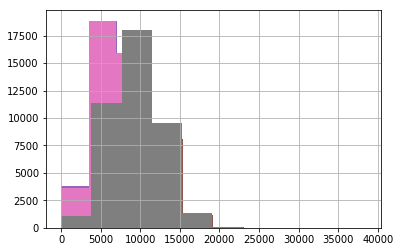

In [45]:
data_raw = pd.read_csv("Kick.csv", # Read the csv into a DF
                   index_col = 'PurchaseID', 
                   na_values = ('?',  '#VALUE!'))

data, data_OH = PreProcessing(data_raw) # PreProcess the data